In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from src.models.models import load_from_checkpoint as lfc
from src.utils.score_utils import metrics_mapping
from src.utils.generation_utils import load_model, all_tfr_decode
import matplotlib.pyplot as plt

import logging
import pandas as pd
import torch
import time

2023-02-06 09:41:18.712997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 09:41:18.713028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
setting = "table2text"
# get generation model with monkey patching based on setting
mod, tok, dset, dec_pref = load_model(setting, True, "cuda:2", False)
dset = list(dset)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing CustomBartModel: ['final_logits_bias']
- This IS expected if you are initializing CustomBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_57/checkpoints/epoch=1-step=50000.ckpt.


using correct weight adjustments
using model  bart-base
FREEZE BART SHARED EMBEDS
freeze embeds


In [3]:
def weightdecay(numtoks):
    return 5/numtoks

def onlytfr(numtoks):
    return 0

#allcands = pd.read_csv("tmp.csv", index_col=0)
def rer_met(rer, tgt, df):
    N=1
    fsort = df.sort_values(by=['ref', rer], ascending=[True, False]).groupby('ref', as_index=False).nth[:N]
    return fsort[tgt].mean()

In [4]:
# get results in a df for a given configuration 
def test_config(mod, tok, data, config):
    allcands = all_tfr_decode(mod, tok, data, config)
    allcands['modsco'] = [float(f) for f in allcands['modsco']]
    metrics_mapping("pqe", allcands)
    metrics_mapping("parent",allcands)
    return allcands

In [5]:
len(dset)

931

In [13]:
allcands = test_config(mod, tok, dset[:100], {
        "max_len":90,
        "device":'cuda:2',
        "beam_size":50,
        "dec_prefix":dec_pref,
        "tfr_interv":6,
        "tfr_beams":13,
        "weightfunc":onlytfr
})

Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
20
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR Rerank Beam Search
Using TFR R

Some weights of the model checkpoint at facebook/bart-base were not used when initializing CustomBartModel: ['final_logits_bias']
- This IS expected if you are initializing CustomBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_57/checkpoints/epoch=1-step=50000.ckpt.


using correct weight adjustments
using model  bart-base
FREEZE BART SHARED EMBEDS
freeze embeds
0.0 %
3.2 %
6.4 %
9.6 %
12.8 %
16.0 %
19.2 %
22.400000000000002 %
25.6 %
28.799999999999997 %
32.0 %
35.199999999999996 %
38.4 %
41.6 %
44.800000000000004 %
48.0 %
51.2 %
54.400000000000006 %
57.599999999999994 %
60.8 %
64.0 %
67.2 %
70.39999999999999 %
73.6 %
76.8 %
80.0 %
83.2 %
86.4 %
89.60000000000001 %
92.80000000000001 %
96.0 %
99.2 %
TOOK TIME  53.04
references loaded
0
1000
0
1000
0
1000
references processed
0
1000
2000
3000
4000
hyps processed
<module 'tqdm' from '/home/prasann/miniconda3/envs/latclone/lib/python3.8/site-packages/tqdm/__init__.py'>
Using 4 processes, starting now
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM

Computing PARENT: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1795.07it/s]


In [15]:
rer_met("pqe","precision", allcands)

0.6763291611468527

In [16]:
allcands['precision'].mean()

0.6018812601044835

In [9]:
allcands.to_csv("output/tfr_cands/t2t_I6_R13_1000.csv")

In [81]:
allcands['weighteoutput/= allcands['modsco']+allcands['pqe']

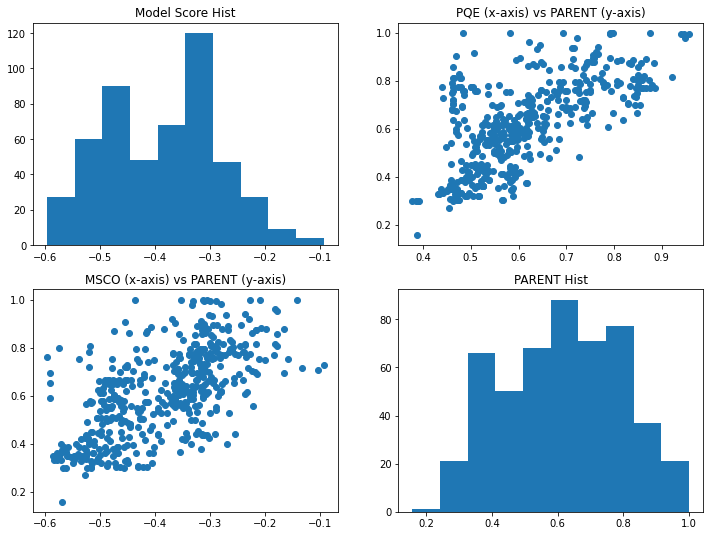

In [82]:
figure, axis = plt.subplots(2, 2, figsize=(12,9))
axis[0, 0].hist(allcands['modsco'])
axis[0, 0].title.set_text("Model Score Hist")
axis[0, 1].scatter(allcands['pqe'], allcands['precision'])
axis[0, 1].title.set_text("PQE (x-axis) vs PARENT (y-axis)")
axis[1, 0].scatter(allcands['modsco'], allcands['precision'])
axis[1, 0].title.set_text("MSCO (x-axis) vs PARENT (y-axis)")
axis[1, 1].hist(allcands['precision'])
axis[1, 1].title.set_text("PARENT Hist")
plt.show()

In [85]:
rer_met("pqe", "precision", allcands)

0.7840100457254089

In [ ]:
# b12 I5 R1 - 12 unique nouns
# b12 I2 R1 - 17 unique nouns
# b12 I2 R2 - 14.9 unique nouns
# b12 I2 R3 - 12.2 unique nouns
# b12 I1 R1 - 30.1 unique nouns (~5x slower though pre-optimization)
# b50 I2 R2 - 23.9 unique nouns (~6x slower)

In [31]:
allcands['hyp'][200]

"Robert Louis Stevenson and Charles Dickens fans have had a Christmas present sent from China - footage of Joseph Poor Joe's death on film."

In [10]:
alldf = []
for i in range(len(dset)):
    for c in allcands[i]:
        alldf.append({
            'ref':dset[i][1],
            'hyp':c
        })

In [11]:
alldf = pd.DataFrame(alldf)

In [12]:
#alldf.to_csv("output/tfr_cands/b12_f5_r1.csv")

In [4]:
alldf= pd.read_csv("output/tfr_cands/b12_f5_r1.csv", index_col=0)

In [5]:
metrics_mapping("utnoun", alldf)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


using model  xlm-roberta-large
FREEZE BART SHARED EMBEDS
freeze embeds
0.0 %
8.88888888888889 %
17.77777777777778 %
26.666666666666668 %
35.55555555555556 %
44.44444444444444 %
53.333333333333336 %
62.22222222222222 %
71.11111111111111 %
80.0 %
88.88888888888889 %
97.77777777777777 %
TOOK TIME  55.81


In [8]:
alldf['unique_nouns'].mean()

9.902916666666666

In [11]:
rer_met("utnoun", "utnoun", alldf)

1.17603822718064

In [21]:
ind = 0
source, ref = dset[ind]

baseline = tfr_decode_ind(mod, tok, source, {
    "max_len":90,
    "device":'cuda:2',
    "beam_size":12,
    "dec_prefix":dec_pref,
    "tfr_interv":3,
    "tfr_beams":1
})

Using TFR Rerank Beam Search


In [22]:
hypsco_dist("noun", baseline, mod, "cuda:2")

[1.2420637607574463,
 1.2428767681121826,
 1.5245153903961182,
 1.2357728481292725,
 1.2348281145095825,
 1.2429105043411255,
 1.24106764793396,
 1.237522840499878,
 1.7258000373840332,
 1.4346632957458496,
 2.02728271484375,
 1.5319263935089111,
 1.5341334342956543,
 1.958558201789856,
 2.0257554054260254,
 0.9216064214706421,
 1.943184733390808,
 1.935782551765442,
 1.5066735744476318,
 1.70225191116333,
 1.9389169216156006,
 1.7082898616790771,
 1.8339855670928955,
 1.9897265434265137,
 1.7195689678192139,
 1.736982822418213,
 1.8327267169952393,
 1.5383846759796143,
 1.7082898616790771,
 1.8403806686401367,
 1.9211424589157104,
 1.8606631755828857,
 1.7180145978927612,
 1.9858286380767822,
 1.922081708908081,
 1.9935083389282227,
 1.7258000373840332,
 1.7258050441741943,
 2.032583236694336,
 1.9496103525161743,
 1.7324702739715576,
 2.017495632171631,
 2.000446319580078,
 1.9897929430007935,
 2.0217442512512207,
 1.995353102684021,
 2.0008511543273926,
 1.9992010593414307,
 1.99073

In [23]:
baseline

['Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View restaurant.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View Restaurant.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View seafood restaurant in the harbour area.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View restaurants.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View hotel.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all militants in a gun and explosion attack at Beach View Hotel.',
 'Security forces in Somali capital Mog Somalia say their forces have killed all milita

In [ ]:
if __name__=="__main__":
    # get model, tokenizer
    mod, tok, dset, dec_pref = load_model("xsum", "cuda:2")

    # get eval version of model (scores given separately)
    # TODO make things efficient to minimize re-calculation of stuff
    tfrmodel = lfc("noun", True).to("cuda:2")
    tfrmodel.eval()

    # manually override to insert our beam_search method 
    mod.beam_search = beam_search.__get__(mod)
    mod.tfr = tfrmodel
    mod.tokenizer = tok
    mod.tfr_interv = 5
    mod.tfr_beams = 1

    # TODO will need to insert TFR model for use as well

    # have some input string
    source, ref = list(dset)[0]
    print("SRC: ", source)
    print("REF: ", ref)
    

    # run algorithm / cross fingers
    base = run_hf_baseline(mod, tok, source, args, False)
    # our goal is for this to match
    preds = run_hf_baseline(mod, tok, source, args, True)
    
    print(preds)